# Papers with Code: Unsupervised Seismic Waveform Classificatio

## 3D Synthetic:

This notebook applies the technique of unsupervised seismic waveform classification to a real-world 3D seismic dataset. The objective is to automatically group seismic traces into different "seismic facies" based on the shape of the waveform around a specific geological horizon. This can help interpreters quickly identify and map geological features like channels, fans, or changes in rock properties across a large area.

The workflow can be broken down into three main stages:
   1. **Data Loading and QC**: Loading the 3D seismic cube and the horizon pick, and ensuring they are correctly aligned.
   2. **Waveform Extraction and Clustering**: Extracting small waveform snippets around the horizon and using a machine learning algorithm (K-Means) to classify hem.
   3. **Analysis and Visualization**: Interpreting the results by looking at the classified map and the characteristics of each seismic facies.

---

To work with real seismic data, we need some specialized toolkits.
* **segysak** is designed for reading and manipulating seismic data in the industry-standard SEGY format.
* **pathlib** is a library that allow us to handle file paths.
* **pandas**  is used for working with tabular data. We'll use it to load our horizon data from a CSV file.
* **xarray** is required by *segysak* since it uses Xarray as its data structure. An Xarray object is like a "smart" NumPy array that keeps track of the labels for each dimension (e.g., iline, xline, twt), which is extremely helpful.

In [1]:
import segysak
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt



from segysak.segy import (
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
)

ModuleNotFoundError: No module named 'segysak'

The first step is to load the 3D seismic cube from the `.sgy` file. For that we define the location if the file in your files (`segyfile_path` = "..."). `xr.open_dataset(...)` is the main *segysak* function to open the file. The most important parameters are:
* `dim_byte_fields`: This tells segysak where to find the inline and crossline numbers in the header of each seismic trace (byte 189 for iline, 193 for xline). This is essential for correctly building the 3D cube.
* `extra_byte_fields`: We also ask segysak to extract the real-world X/Y coordinates (`cdp_x`, `cdp_y`).
* `cube.segysak.scale_coords()`: A utility function that applies any scaling factors from the SEGY file to the coordinates.

In [31]:
segyfile_path = "C:/Users/Windows/Downloads/1_Original_Seismics.sgy"

In [32]:
segy_file = pathlib.Path(segyfile_path)
cube = xr.open_dataset(
    segy_file,
    dim_byte_fields={"iline": 189, "xline": 193},
    extra_byte_fields={"cdp_x": 181, "cdp_y": 185},
)
cube.segysak.scale_coords()

Processing Chunks:   0%|          | 0.00/7.00 [00:00<?, ? trace-chunks/s]
Processing Chunks:  14%|█▍        | 1.00/7.00 [00:01<00:07, 1.32s/ trace-chunks]
Processing Chunks:  29%|██▊       | 2.00/7.00 [00:02<00:06, 1.34s/ trace-chunks]
Processing Chunks:  43%|████▎     | 3.00/7.00 [00:04<00:05, 1.36s/ trace-chunks]
Processing Chunks:  57%|█████▋    | 4.00/7.00 [00:05<00:04, 1.35s/ trace-chunks]
Processing Chunks:  71%|███████▏  | 5.00/7.00 [00:06<00:02, 1.34s/ trace-chunks]
Processing Chunks:  86%|████████▌ | 6.00/7.00 [00:08<00:01, 1.33s/ trace-chunks]


With this we verify that the file was successfully loaded into our system.

In [33]:
print("Loaded cube size: {}".format(cube.segysak.humanbytes))

Loaded cube size: 1.08 GB


---

Now, we need to load the picked horizon from a .csv file. For that we use the function `pd.read_csv(...)`, and add the file location which contains the `cdp_x`, `cdp_y`, and `twt` (two-way time) columns. The result, hrz, is a table of our horizon picks.

In [34]:
hrz_file = pathlib.Path("C:/Users/Windows/Downloads/Horizon.csv")
hrz = pd.read_csv(hrz_file, names=["cdp_x", "cdp_y", "twt"], sep=",")
hrz.head()

,cdp_x,cdp_y,twt
0,605849.1245,6073608.443,869.721680
1,605899.1245,6073608.443,867.726074
2,605949.1245,6073608.443,867.871277
3,605999.1245,6073608.443,865.660034
4,606049.1245,6073608.443,863.562866


To check if the horizon is correctly located  we can create a map plot. For that, we grid the scattered horizon points (`Z = griddata(...)`) and displays them as a colored surface representing the horizon's structure. It then overlays the outline of the 3D seismic survey. This plot visually confirms that our horizon lies within the seismic data boundaries.

In [36]:
from scipy.interpolate import griddata

xi = np.linspace(hrz.cdp_x.min(), hrz.cdp_x.max(), 250)
yi = np.linspace(hrz.cdp_y.min(), hrz.cdp_y.max(), 250)
X, Y = np.meshgrid(xi, yi)
Z = griddata((hrz.cdp_x, hrz.cdp_y), hrz.twt, (X, Y), rescale=True)

* Cell 38 & 39 perform a key data integration step:
           * cube.seis.surface_from_points(): This function intelligently interpolates our scattered horizon points onto the seismic cube's regular
             inline/crossline grid.
           * cube.data.interp(): This function then extracts the seismic amplitude value at every point along that newly created horizon surface.
       * Cell 41 plots the result: a horizon amplitude map. This is a classic seismic attribute that can reveal geological features directly on the
         horizon.

Text(0.5, 1.0, 'Top Hugin fm.')

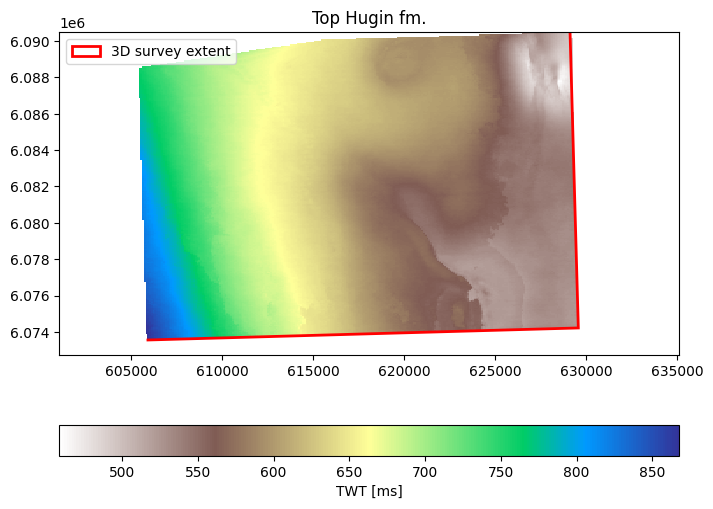

In [ ]:
ff, ax = plt.subplots(figsize=(8, 6))
pp = ax.pcolormesh(X, Y, Z, cmap="terrain_r")
f.colorbar(pp, orientation="horizontal", label="TWT [ms]")
ax.axis("equal")
ax.legend()
ax.set_title("Horizon Map")

In [ ]:
cube = cube.set_coords(('cdp_x', 'cdp_y'))
hrz_mapped = cube.seis.surface_from_points(hrz, "twt", right=("cdp_x", "cdp_y"))

We can then, extract the amplitude value along the imported volume, and display the results in a map view.

In [ ]:
amp = cube.data.interp(
    {"iline": hrz_mapped.iline, "xline": hrz_mapped.xline, "samples": hrz_mapped.twt}
)

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))
amp.plot(cmap="RdYlBu")
#cs = plt.contour(amp.xline, amp.iline, hrz_mapped.twt, levels=20, colors="grey")
#plt.clabel(cs, fontsize=10, fmt="%.0f")
ax.invert_xaxis()

---

In the following section we will perform the waveform extraction and K-Means Clustering. For that we need to following steps:
1. **Define Parameters**: We set key parameters:
* `n_above`, `n_below`: Defines a small window of seismic samples (e.g., 5 samples above and 5 below the horizon) to analyze.
* `k_final`: The number of clusters (seismic facies) we want to find. Here, we choose 8.
2. **Extract Wavelets**: The code first converts the horizon's two-way time (in milliseconds) into a sample index for each trace. It then uses these indices to "grab" the small vertical snippet of the seismic trace (our analysis window) at every location in the cube. This efficiently extracts thousands of individual waveforms.
3. **Run K-Means**: The extracted waveforms are flattened into a 2D table (where each row is one waveform) and fed into the KMeans algorithm. The algorithm analyzes the shape of every waveform and assigns it to one of the 8 clusters.
4. **Create Cluster Map**: The resulting cluster labels are put back onto the 2D inline/crossline grid, creating our final cluster_map.

In [ ]:
# ------------------------------------------------------------------
n_above   = 5           # samples above the horizon
n_below   = 5           # samples below the horizon
k_final   = 8           # number of clusters you want to keep
k_max     = 11          # max k for the elbow test
cmap_clust = ListedColormap(['red','blue','green','orange','purple', 'cyan', 'pink', 'magenta'])

In [ ]:
# ------------------------------------------------------------------
# 1.  build sample‑index window around the horizon for every trace
# ------------------------------------------------------------------
samp = cube.samples.values                    # ms
dt   = np.diff(samp).mean()                   # sample interval (ms)
n_il , n_xl = cube.iline.size , cube.xline.size
n_samp      = samp.size

# horizon twt → nearest sample index
idx0 = (hrz_mapped.twt / dt).round().astype(int).values        # (IL,XL)
idx0 = np.clip(idx0, 0, n_samp-1)

# window of length W = n_above+n_below+1
win = np.arange(-n_above, n_below+1)                           # (W,)
idx_window = idx0[...,None] + win                              # (IL,XL,W)
idx_window = np.clip(idx_window, 0, n_samp-1)

# gather amplitudes: cube.data dims = (IL,XL,S)
d = cube.data.values
IL = np.arange(n_il)[:,None,None]
XL = np.arange(n_xl)[None,:,None]
wavelets = d[IL, XL, idx_window]                               # (IL,XL,W)

# mask traces where horizon is missing --------------------------
mask = np.isfinite(hrz_mapped.twt.values)
wavelets_flat = wavelets[mask]                                 # (N,W)

We use the *Elbow Method* to provide a quantitative justification for our choice of `k=8` clusters.The following plot shows the "Sum of Squared Errors" (SSE) for different numbers of clusters. The "elbow" of the curve (where the rate of improvement drops off) suggests a good number of clusters. Here, the elbow is around `k=8`, supporting our choice.

In [ ]:
# ------------------------------------------------------------------
# 2.  Elbow Method
# ------------------------------------------------------------------
from sklearn.cluster import KMeans
sse = []
for k in range(1, k_max+1):
    km = KMeans(n_clusters=k, random_state=0, n_init='auto')
    km.fit(wavelets_flat)
    sse.append(km.inertia_)

In [ ]:
# ------------------------------------------------------------------
# 3.  Elbow Plot
# ------------------------------------------------------------------
plt.figure(figsize=(5,3))
plt.plot(range(1,k_max+1), sse, 'o-')
plt.axvline(k_final, color='r', ls='--')
plt.title('Elbow test'); plt.xlabel('k'); plt.ylabel('SSE')
plt.grid()
plt.show()

In [ ]:
# ------------------------------------------------------------------
# 3.  final k‑means with k_final  ---------------------------------
# ------------------------------------------------------------------
kmeans = KMeans(n_clusters=k_final, random_state=0, n_init='auto')
cluster_labels = kmeans.fit_predict(wavelets_flat)

# put labels back on the (IL,XL) grid
cluster_map = np.full((n_il, n_xl), np.nan)
cluster_map[mask] = cluster_labels

c:\Users\Windows\anaconda3\envs\seismicWaveformClassif\Lib\site-packages\xarray\core\duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


To understand the seismic character of each classified facies, we calculate the average waveforms per Cluster. This is the most important plot for geological interpretation. This code calculates and plots the average waveform for each of the 8 clusters. By examining these plots, an interpreter can assign meaning to each facies (e.g., "Cluster 1 is a high-amplitude peak," "Cluster 2 is a trough-peak doublet," etc.).

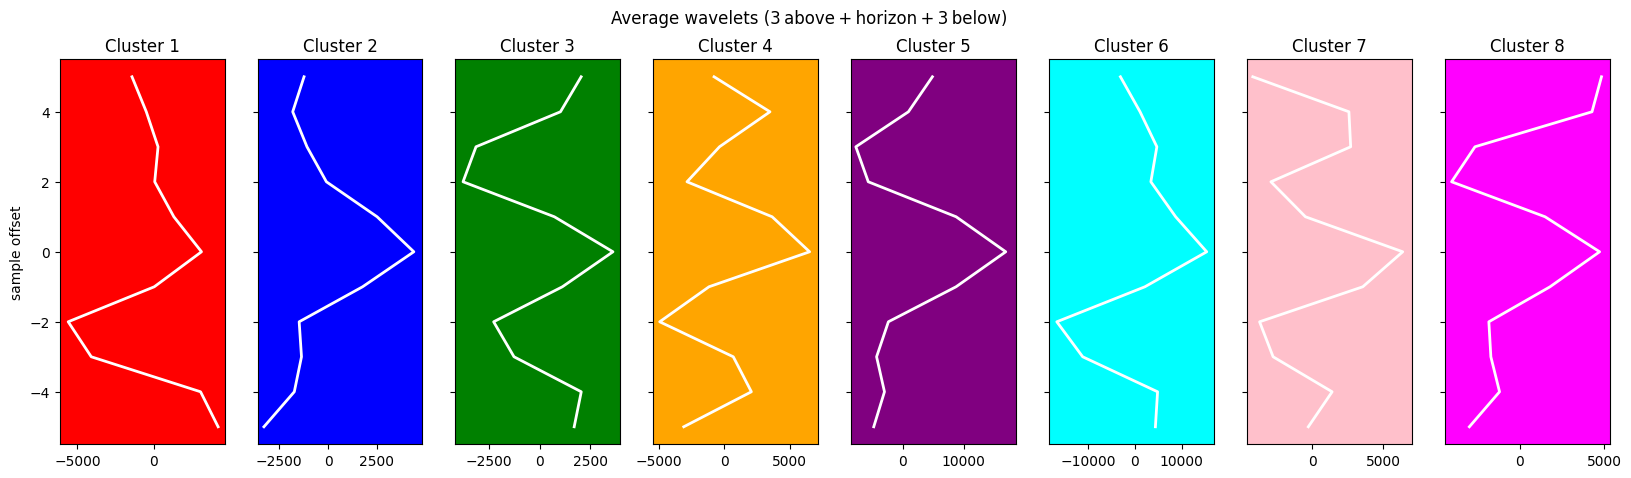

In [47]:
# ------------------------------------------------------------------
# 5.  average waveforms per cluster  ------------------------------
# ------------------------------------------------------------------
fig_w, axs = plt.subplots(1, k_final, figsize=(2.5*k_final, 5), sharey=True)
for c in range(k_final):
    w = wavelets_flat[cluster_labels == c]
    mean_w = w.mean(axis=0) if w.size else np.zeros(len(win))
    axs[c].plot(mean_w, win[::-1], color='white', lw=2)
    axs[c].set_facecolor(cmap_clust(c))
    axs[c].set_title(f'Cluster {c+1}')
    axs[c].set_xlim(mean_w.min()*1.1, mean_w.max()*1.1)
    axs[c].invert_yaxis()
    axs[c].set_ylabel('sample offset' if c==0 else '')
plt.suptitle('Average wavelets (3 above + horizon + 3 below)')
plt.show()

Then, we can generate a final Classification Map, in order to visualize the spatial distribution of the seismic facies. his map uses a distinct color for each of the 8 clusters. It allows the interpreter to see geological patterns, such as channels or fans,emerging from the classification.

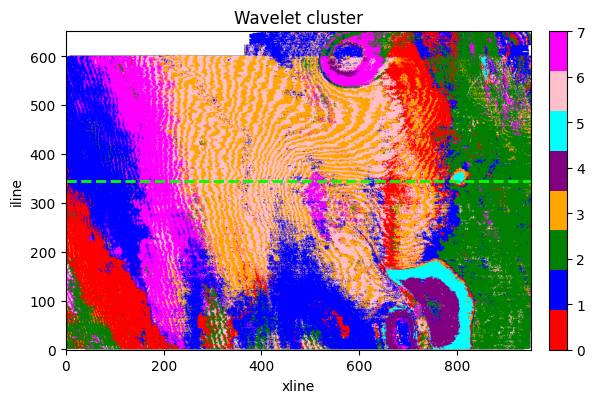

In [48]:
inline_mark = 445
row_idx = np.where(cube.iline.values == inline_mark)[0][0]

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(cluster_map, cmap=cmap_clust, origin='lower')
ax.axhline(row_idx, color='lime', ls='--', lw=2)

ax.set_xlabel('xline')
ax.set_ylabel('iline')
ax.set_title('Wavelet cluster')

# ----------------------------------------------------------
# NEW: add a standalone colour‑bar axis with a clear margin
# ----------------------------------------------------------
pos = ax.get_position()                 # [left, bottom, width, height]
gap = 0.03                              # fractional gap of the figure width
cbar_width = 0.03                       # width of the colour‑bar axis

cax = fig.add_axes([pos.x1 + gap,       # left edge = map right edge + gap
                    pos.y0,             # bottom aligned to image
                    cbar_width,         # width
                    pos.height])        # full height of the map

fig.colorbar(im, cax=cax, ticks=np.arange(k_final))   # or customise ticks

plt.show()


To tie the classification results directly back to the raw seismic data, we can generate an inline visualization with Cluster Overlay. With the next code, we display the same inline (445) as before, but now with colored bars overlaid on the seismic. Each bar's color corresponds to the cluster that the trace was assigned to. This provides a direct, intuitive link between the seismic waveform at a location and the facies map, completing the interpretation workflow.

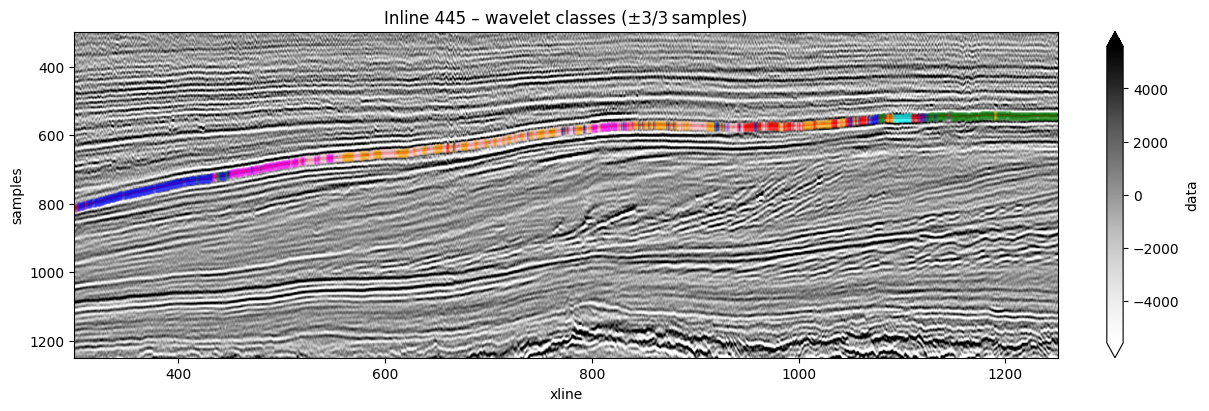

In [53]:
# ------------------------------------------------------------------
# DISPLAY ONE INLINE 445  (xline 300 → 1250, left→right)
# ------------------------------------------------------------------
inline_target = 445          # inline you want
cmap_clust = ListedColormap(['red','blue','green','orange','purple', 'cyan', 'pink', 'magenta'])

bar_alpha = 0.4

avail_il = cube.iline.values
il = avail_il[np.abs(avail_il - inline_target).argmin()]
il_idx = np.where(avail_il == il)[0][0]

hline      = hrz_mapped.sel(iline=il, method="nearest")
x_vals     = hline.xline.values
twt_vals   = hline.twt.values
cluster_ids = cluster_map[il_idx, :]

dt_ms = np.diff(cube.samples.values).mean()

fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)

cube.data.sel(iline=il, samples=slice(300, 1250)).plot.imshow(ax=ax, **opt)

ax.plot(x_vals, twt_vals, color='r', lw=1)           # horizon

for xl, twt, cid in zip(x_vals, twt_vals, cluster_ids):
    if np.isfinite(cid):
        top    = twt - n_above * dt_ms
        bottom = twt + n_below * dt_ms
        ax.plot([xl, xl], [top, bottom],
                color=cmap_clust.colors[int(cid)],
                linewidth=2,
                solid_capstyle='butt',
                alpha=bar_alpha)

# note: no invert_xaxis()  →  xline now increases L→R
ax.set_title(f"Inline {il} – wavelet classes (±{n_above}/{n_below} samples)")
plt.show()


Now, if we want to make a more detailed view of the results we can only select the time between 500 - 900 ms.

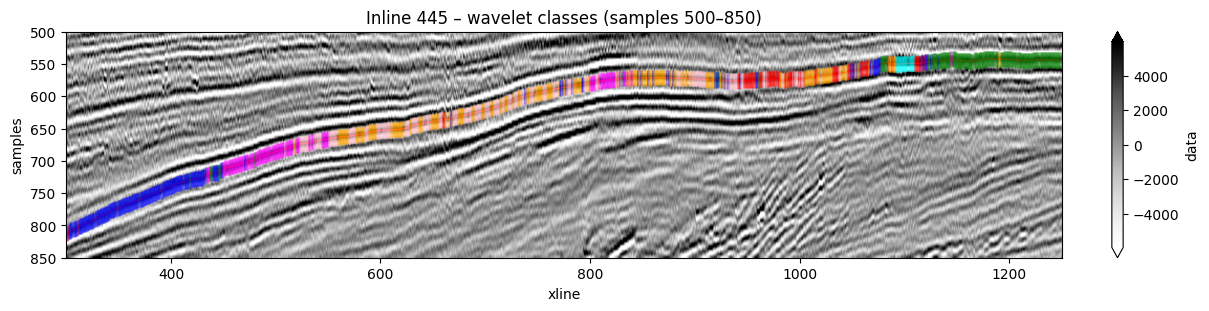

In [54]:
# ------------------------------------------------------------------
# DISPLAY ONE INLINE 445, samples 500‑900, xline 300 → 1250
# ------------------------------------------------------------------
#inline_target = 445
#n_above, n_below = 3, 3
plot_top, plot_bottom = 500, 850
#colours  = ['red','blue','green','orange','purple']
bar_alpha = 0.4

avail_il = cube.iline.values
il = avail_il[np.abs(avail_il - inline_target).argmin()]
il_idx = np.where(avail_il == il)[0][0]

hline       = hrz_mapped.sel(iline=il, method="nearest")
x_vals      = hline.xline.values
twt_vals    = hline.twt.values
cluster_ids = cluster_map[il_idx, :]

dt_ms = np.diff(cube.samples.values).mean()

fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

# seismic slice 500‑900
cube.data.sel(iline=il, samples=slice(plot_top, plot_bottom)).plot.imshow(ax=ax, **opt)

# horizon
ax.plot(x_vals, twt_vals, color='r', lw=1)

# coloured bars
for xl, twt, cid in zip(x_vals, twt_vals, cluster_ids):
    if np.isfinite(cid):
        top, bottom = twt - n_above*dt_ms, twt + n_below*dt_ms
        if bottom < plot_top or top > plot_bottom:
            continue
        ax.plot([xl, xl],
                [max(top,   plot_top),
                 min(bottom, plot_bottom)],
                color=cmap_clust.colors[int(cid)],
                lw=2, solid_capstyle='butt', alpha=bar_alpha)

# styling
ax.set_ylim(plot_bottom, plot_top)     # depth positive downward
# no invert_xaxis()  →  xline runs 300 → 1250 left→right
ax.set_title(f"Inline {il} – wavelet classes (samples {plot_top}–{plot_bottom})")
plt.show()
